## A) Import libs

In [ ]:
#import libs
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt 
import math
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import ipywidgets as widgets
from ipywidgets import interact

# import files 
from DataSet import DataSet
from DataGen import DataGen 
from FixedGP import FixedGP 
from DataGen import DataGen
from utilities import standardize_vector, map_plot, labeled_inputs_plot, compare_output_label, plot_combinations
#from MapUpdateNetwork import MapUpdateNetwork

## B) Load data from pth file

In [ ]:
name = 'test_5que_10kcomb'

In [10]:
# Load the saved data from a .pth file using PyTorch
loaded_data = torch.load('dataset/og_'+name+'.pth', weights_only=True)  
# The 'weights_only=True' argument ensures that only the model weights (not the entire model) are loaded

# Access the tensors and the description from the loaded data
train_input = loaded_data["train_input"]  # The input data for training
train_label = loaded_data["train_label"]  # The corresponding labels for the training data
loaded_description = loaded_data["description"]  # The description or metadata associated with the data

print(loaded_description)

These labeled inputs have the original form.
These labeled inputs were made with these parameters:
 name: test_5que_10kcomb
 nb_queries: 5
 nb_comb: 10000
 kernel_type: Mat52
 noise_std: 0.1
 output_std: 3
 lengthscale: [0.14285714285714285, 0.3333333333333333]


### Visualize the labeled data 

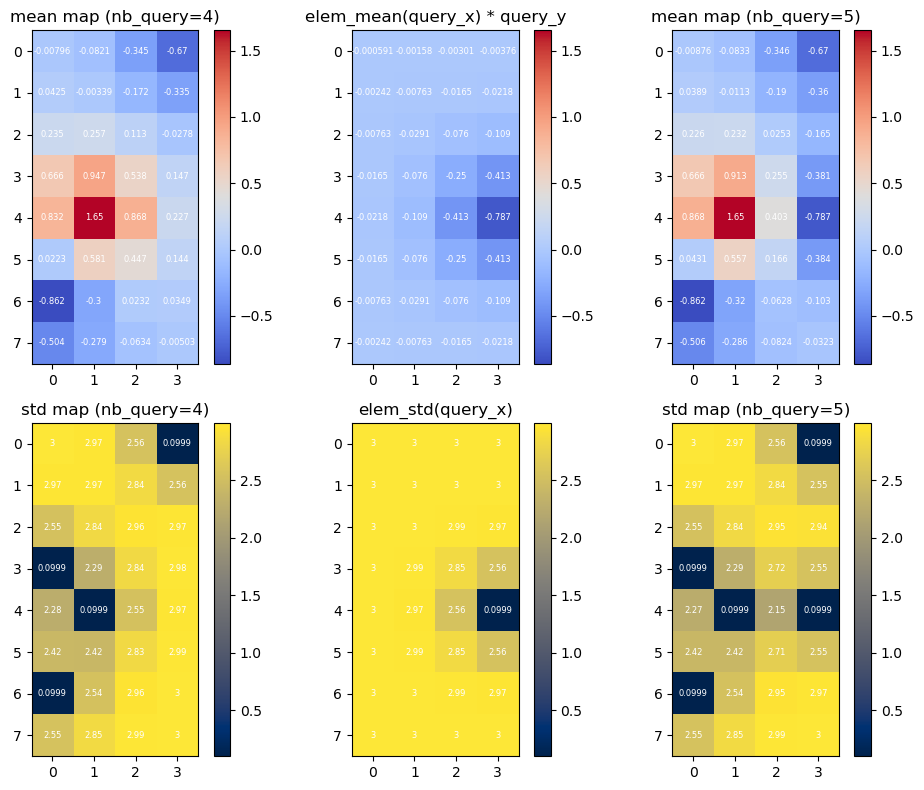

In [11]:
labeled_inputs_plot(train_input=train_input, train_label=train_label, comb_idx=0, values=True)

## C) Build NN model

In [12]:
class MapUpdateNetwork(nn.Module):
    """
    A convolutional neural network designed for processing and updating map-like structures.
    The network takes four input images as input, encodes their features, and decodes them 
    to generate an output map of the same spatial dimensions as the inputs.

    Attributes:
        encoder (nn.Sequential): Encoder that reduces spatial dimensions and extracts high-level features.
        decoder (nn.Sequential): Decoder that reconstructs the spatial dimensions from encoded features.

    Methods:
        __init__(in_channels, out_channels, out_channels_first_conv):
            Initializes the network with configurable input/output channels and feature depth.
        forward(img1, img2, img3, img4):
            Performs the forward pass by concatenating the input images, encoding their features, 
            and decoding them to produce the final map.
    """

    def __init__(self, in_channels=4, out_channels=2, out_channels_first_conv=16):
        """
        Initializes the MapUpdateNetwork.

        Args:
            in_channels (int): Number of input channels. Defaults to 4 (for concatenated input images).
            out_channels (int): Number of output channels. Defaults to 2.
            out_channels_first_conv (int): Number of channels in the first convolutional layer. Defaults to 16.
        """
        super(MapUpdateNetwork, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 64 x 4x2 => 32 x 4x2
            nn.ReLU(),
            nn.ConvTranspose2d(2*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 x 4x2 => 16 x 8x4
            nn.ReLU()
        )
        self.final_layer1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.final_layer2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()
        )

    def forward(self, img1, img2, img3, img4):
        """
        Forward pass of the network. Combines four input images, processes them through
        an encoder-decoder architecture, and outputs an updated map.

        Args:
            img1 (torch.Tensor): First input image tensor of shape (B, C, H, W).
            img2 (torch.Tensor): Second input image tensor of shape (B, C, H, W).
            img3 (torch.Tensor): Third input image tensor of shape (B, C, H, W).
            img4 (torch.Tensor): Fourth input image tensor of shape (B, C, H, W).

        Returns:
            torch.Tensor: Output map tensor of shape (B, out_channels, H, W), where 
                          H and W are the height and width of the input images.
        """
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder(x)
        channel1 = self.final_layer1(x)  # Output non contraint
        channel2 = 3 * self.final_layer2(x)  # Contraint entre [0, 3]
        return torch.cat((channel1, channel2), dim=1)

In [13]:
class MapUpdateNetwork(nn.Module):
    def __init__(self, in_channels=4, out_channels_first_conv=16):
        super(MapUpdateNetwork, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        
        # Decoder for 2 outputs 
        self.decoder_shared = nn.ConvTranspose2d(4*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1) # 64 x 4x2 => 16 x 8x2
        self.decoder_output1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.decoder_output2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()  # Normalisation [0, 1]
        )

    def forward(self, img1, img2, img3, img4):
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder_shared(x)
        
        # 2 different outputs 
        output1 = self.decoder_output1(x)  
        output2 = self.decoder_output2(x) * 3  # Rescale pour [0, 3]
        
        return torch.cat((output1, output2), dim=1)


In [14]:
class MapUpdateNetwork(nn.Module):
    def __init__(self, in_channels=4, out_channels_first_conv=16):
        super(MapUpdateNetwork, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 4 x 8x4 => 16 x 8x4
            nn.ReLU(),
            nn.Conv2d(out_channels_first_conv, 2*out_channels_first_conv, kernel_size=3, stride=2, padding=1), # 16 x 8x4 => 32 x 4x2
            nn.ReLU(),
            nn.Conv2d(2*out_channels_first_conv, 4*out_channels_first_conv, kernel_size=3, stride=1, padding=1), # 32 x 4x2 => 64 x 4x2
            nn.ReLU()
        )
        
        # Decoder for 2 outputs 
        self.decoder_shared = nn.Sequential(
            nn.ConvTranspose2d(4*out_channels_first_conv, out_channels_first_conv, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 x 4x2 => 16 x 8x2
            nn.ReLU()
        )
        self.decoder_output1 = nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1) # 16 x 8x4 => 1 x 8x4
        self.decoder_output2 = nn.Sequential(
            nn.Conv2d(out_channels_first_conv, 1, kernel_size=3, stride=1, padding=1), # 16 x 8x4 => 1 x 8x4
            nn.Sigmoid()  # Normalisation [0, 1]
        )

    def forward(self, img1, img2, img3, img4):
        x = torch.cat((img1, img2, img3, img4), dim=1)
        x = self.encoder(x)
        x = self.decoder_shared(x)
        
        # 2 different outputs 
        output1 = self.decoder_output1(x)  
        output2 = self.decoder_output2(x) * 3  # Rescale pour [0, 3]
        
        return torch.cat((output1, output2), dim=1)

## D) Training settings

In [15]:
train_X = train_input[:7000]
train_Y = train_label[:7000]

validation_X = train_input[7000:8500]
validation_Y = train_label[7000:8500]

test_X = train_input[8500:]
test_Y = train_label[8500:]

In [ ]:
# Assuming train_X, train_Y, validation_X, validation_Y, test_X, test_Y are provided
batch_size = 32  # Batch size for DataLoader

# Create datasets and data loaders
train_dataset = TensorDataset(train_X, train_Y)
validation_dataset = TensorDataset(validation_X, validation_Y)
test_dataset = TensorDataset(test_X, test_Y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MapUpdateNetwork()

criterion1 = nn.MSELoss()
criterion2 = nn.MSELoss()  # Si les valeurs dans [0, 3] représentent des classes discrètes

def custom_loss(output, targets):
    target1 = targets[:, 0]  # Extraire les cibles pour le premier canal
    target2 = targets[:, 1]  # Extraire les cibles pour le deuxième canal
    loss1 = criterion1(output[:, 0], target1)
    loss2 = criterion2(output[:, 1], target2) 
    return loss1 + loss2

optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# Define training function
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=20, device="cpu"):
    """
    Trains the given model using the provided data loaders.

    Args:
        model (nn.Module): The neural network to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        validation_loader (DataLoader): DataLoader for the validation dataset.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        num_epochs (int): Number of epochs to train. Default is 20.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        model (nn.Module): Trained model.
    """
    model.to(device)
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(*torch.split(inputs, 1, dim=1))  # Split into 4 inputs
            loss = custom_loss(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(*torch.split(inputs, 1, dim=1))
                loss = custom_loss(outputs, targets)
                validation_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}] - "
              f"Train Loss: {train_loss / len(train_loader):.10f}, "
              f"Validation Loss: {validation_loss / len(validation_loader):.10f}")

    return model

In [18]:
# Define evaluation function
def evaluate_model(model, test_loader, criterion, device="cpu"):
    """
    Evaluates the trained model on a test dataset.

    Args:
        model (nn.Module): Trained neural network.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (nn.Module): Loss function.
        device (str): Device to use ('cpu' or 'cuda'). Default is 'cpu'.

    Returns:
        float: Average loss on the test set.
    """
    model.eval()
    model.to(device)
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(*torch.split(inputs, 1, dim=1))
            loss = custom_loss(outputs, targets)
            test_loss += loss.item()
    return test_loss / len(test_loader)

## E) Training 

In [20]:
# Train the model
num_epochs = 10
trained_model = train_model(model, train_loader, validation_loader, custom_loss, optimizer, num_epochs, device)

Epoch [1/10] - Train Loss: 0.1719659537, Validation Loss: 0.0902910694
Epoch [2/10] - Train Loss: 0.0653364564, Validation Loss: 0.0445447582
Epoch [3/10] - Train Loss: 0.0398565645, Validation Loss: 0.0319529662
Epoch [4/10] - Train Loss: 0.0306970168, Validation Loss: 0.0267996324
Epoch [5/10] - Train Loss: 0.0256080652, Validation Loss: 0.0276381148
Epoch [6/10] - Train Loss: 0.0226679879, Validation Loss: 0.0208989512
Epoch [7/10] - Train Loss: 0.0205264278, Validation Loss: 0.0213039764
Epoch [8/10] - Train Loss: 0.0189324087, Validation Loss: 0.0173057127
Epoch [9/10] - Train Loss: 0.0182022442, Validation Loss: 0.0173874125
Epoch [10/10] - Train Loss: 0.0169368438, Validation Loss: 0.0153187993


In [ ]:
# Train the model
num_epochs = 10
trained_model = train_model(model, train_loader, validation_loader, custom_loss, optimizer, num_epochs, device)

Epoch [1/10] - Train Loss: 0.9224576313, Validation Loss: 0.3344519310
Epoch [2/10] - Train Loss: 0.1663249418, Validation Loss: 0.0873590668
Epoch [3/10] - Train Loss: 0.0684849770, Validation Loss: 0.0510202393
Epoch [4/10] - Train Loss: 0.0427799181, Validation Loss: 0.0349405716
Epoch [5/10] - Train Loss: 0.0328107984, Validation Loss: 0.0271875524
Epoch [6/10] - Train Loss: 0.0280307735, Validation Loss: 0.0253285242
Epoch [7/10] - Train Loss: 0.0242136758, Validation Loss: 0.0213146373
Epoch [8/10] - Train Loss: 0.0210987597, Validation Loss: 0.0188681915
Epoch [9/10] - Train Loss: 0.0192767197, Validation Loss: 0.0173276203
Epoch [10/10] - Train Loss: 0.0174080217, Validation Loss: 0.0182337167


In [ ]:
# Train the model
num_epochs = 10
trained_model = train_model(model, train_loader, validation_loader, custom_loss, optimizer, num_epochs, device)

NameError: name 'train_model' is not defined

## F) RESULTS

In [21]:
# Evaluate the model on the test set
test_loss = evaluate_model(trained_model, test_loader, custom_loss, device)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0157


## G) Postprocess

In [23]:
outputs = model(*torch.split(train_X[0:10], 1, dim=1))

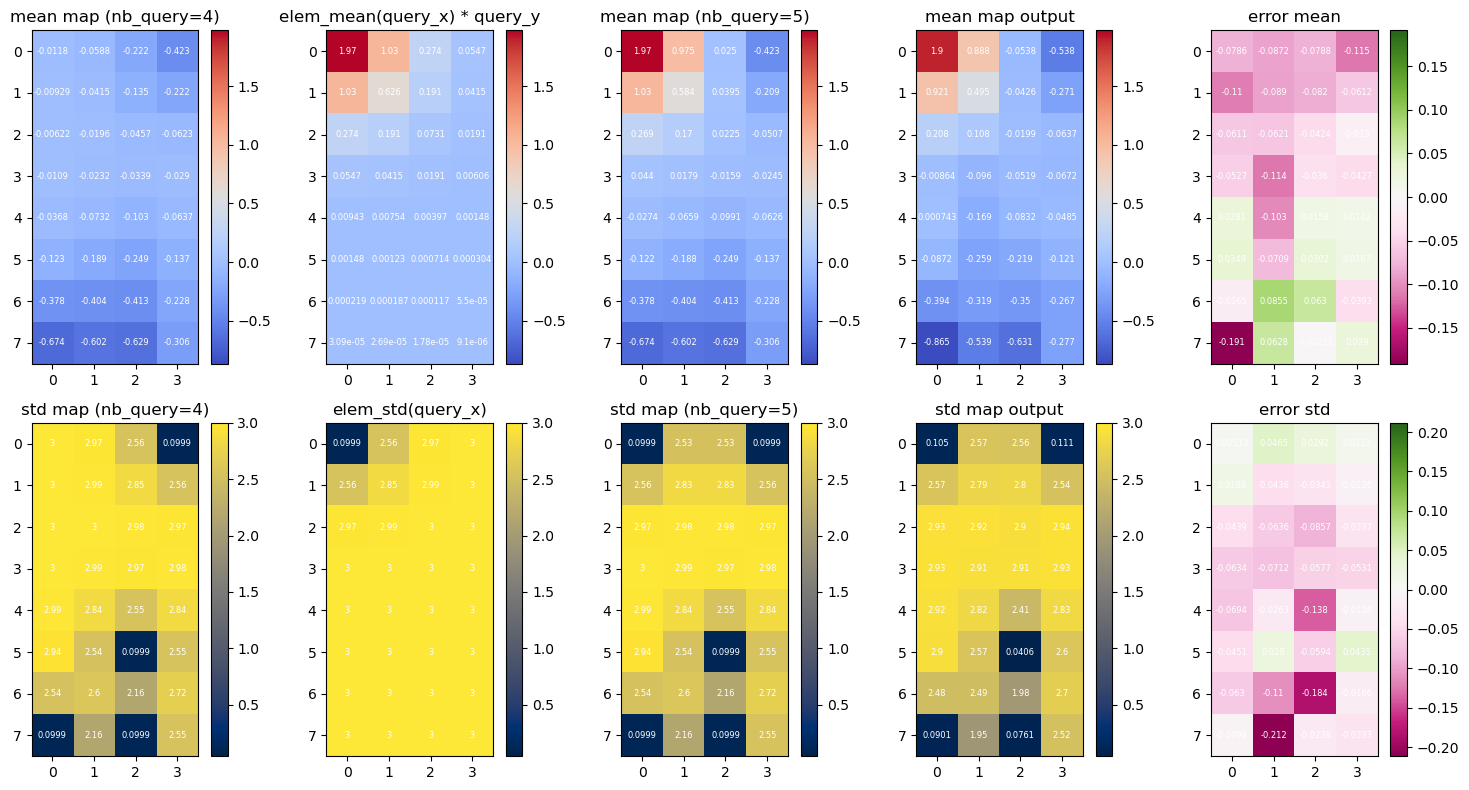

In [25]:
compare_output_label(train_input=train_X, train_label=train_Y, output=outputs.detach(), comb_idx=2, values=True)

In [ ]:
plot_combinations(train_input=train_X, train_label=train_Y, output=outputs.detach(), comb_idx_range=(0, 9), values=True)

interactive(children=(IntSlider(value=0, description='Comb Index', max=9), Output()), _dom_classes=('widget-in…